# Lab 4.2 Time Series Clustering

**Nikos Kordalis**


For this homework, we will once again use the global long-term sea-surface temperature data from NOAA:  https://www.esrl.noaa.gov/psd/data/gridded/data.cobe.html

The essential steps for this homework are:

1.	Load the dataset into Python
2.	Normalize the time series data
3.	Perform a hierarchical clustering
4.	Present figures showing your work

**Question 1: Please provide the code that you used to load and normalize your time series data. (10 points).** 

### Load modules

In [3]:
import numpy as np
from scipy.spatial.distance import pdist #pdist find distance between points
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram 
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
import datetime
import dask.array as da
from scipy.cluster.hierarchy import linkage
import os
from netCDF4 import Dataset

In [5]:
sst_mean1 = 'sst.mon.mean.nc'
dataset= Dataset(sst_mean1, 'r')

In [11]:
print(dataset.variables.keys()) 

odict_keys(['lat', 'lon', 'time', 'sst'])


In [12]:
print(dataset.variables['time'].dimensions)
print(dataset.variables['time'].shape)

('time',)
(1551,)


In [6]:
sst_mean= dataset.variables['sst'][:]
data = sst_mean.data
date = dataset.variables['time'][:].data
data.shape
#data

(1551, 180, 360)

### Replace large values with NaN
In the dataset the masked values will be replaced with a large number which we replace with NaN.

In [13]:
mask_sst = sst_mean.mask
data[mask_sst==True]=np.nan 

### Normalize the data

In [14]:
def fx(x):
    return (x - np.nanmean(x)) / np.nanstd(x)
ds_clean = np.apply_along_axis(fx, axis=0, arr=data)
ds_clean.shape

/home/student/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/student/anaconda3/envs/BigData/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/student/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(1551, 180, 360)

**Question 2:Please provide the cluster dendrogram as an image, and choose an optimal number of clusters. Explain why you chose those clusters, with justification. For example, you could look for evenly sized clusters, or clusters that have low internal variance. (20 points).** 

In [ ]:
mask = np.isnan(ds_clean[0, : , :])
d = ds_clean[:, ~mask].T
print(d.shape)

**Linkage matrices**

In [20]:
method = 'complete'
metric = 'correlation'
linkage_file = 'linkage_sst-%s-%s.npy' % (method, metric) 
if not os.path.exists(linkage_file):
    z = linkage(d, method = method, metric = metric)
    np.save(linkage_file, z)
else:
    z = np.load(linkage_file) 

In [56]:
def clusters(cutoff):
 #Create the clusters
    clst = fcluster(z, cutoff, criterion='distance')
 #Create an empty array to hold the clusters
    ci = np.ones(180 * 360)
    ci.fill(np.nan)
    ci[~mask.ravel()] = clst
    ci = ci.reshape((180, 360))
    return ci, clst

In [95]:
def colorbar_cartopy(mappable, cmap, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05, axes_class=plt.Axes, autoscale_on=False)
    obj = fig.colorbar(cmap, cax=cax, **kwargs)
    return obj

In [120]:
from scipy.cluster.hierarchy import fcluster, dendrogram
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
def plot2(cutoff,ci,clst): 
        f, (ax,ax2) = plt.subplots(1,2, figsize=(15,5))
        
        ax.set_title('Cutoff: ' + str(cutoff))
        ax.set_title(str(cutoff))
        dendrogram(z, ax=ax, p=4, truncate_mode='level')
        ax.plot((0,1000), (cutoff,cutoff), 'k--', linewidth=2)
        ax.grid()
        
        a = ax2.imshow(ci,origin='upper',cmap=plt.cm.Set1)   
        num_clusts = np.unique(clst).shape[0]
        cb = colorbar_cartopy(ax2, a)
        cb.set_label('Cluster Label')
        #cb.ax.yaxis.set_ticks(range(num_clusts))
        ax2.set_title('{} Clusters'.format(num_clusts))

In [171]:
ci20, clst20 = clusters(0.75)
ci22, clst22 = clusters(0.73)
ci23, clst23 = clusters(0.72)
ci25, clst25 = clusters(0.7)
ci26, clst26 = clusters(0.65)

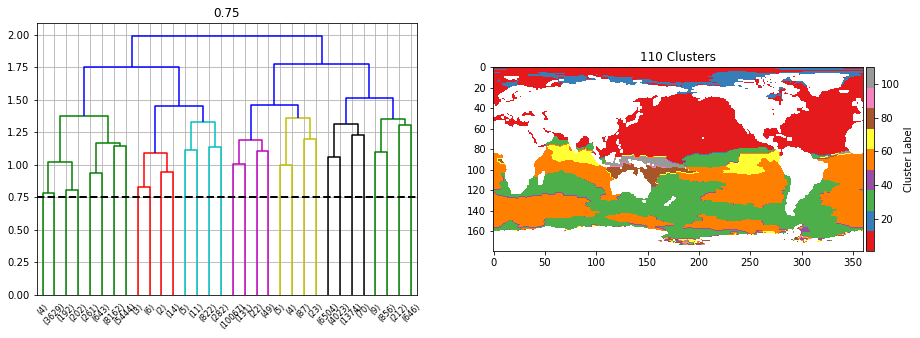

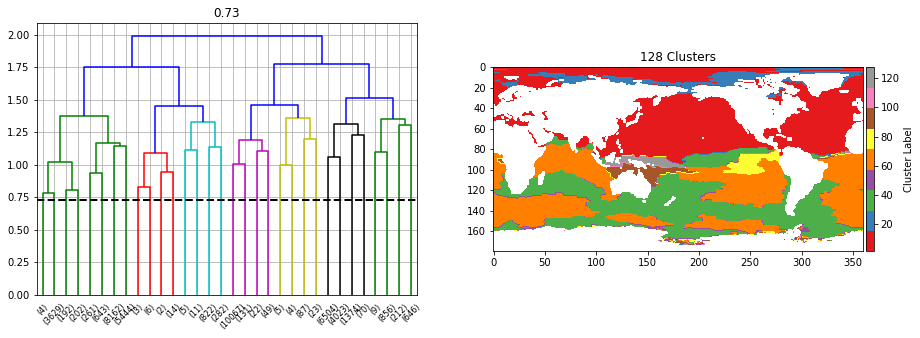

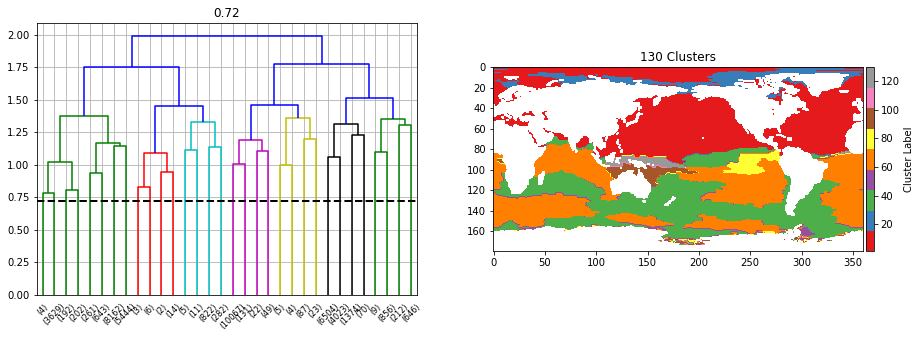

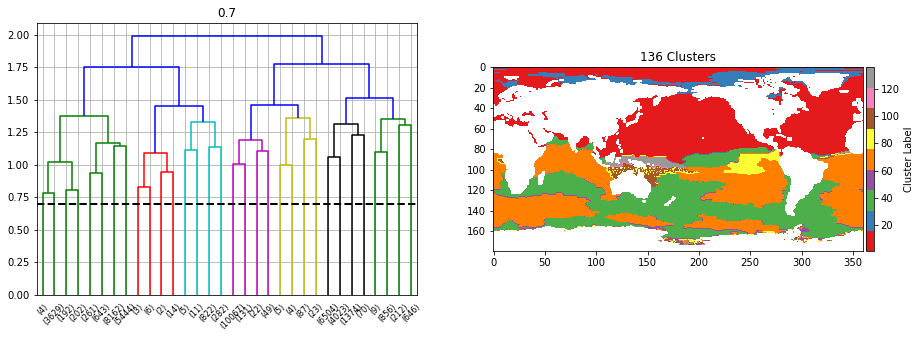

In [173]:
plot2(0.75,ci20, clst20)
plot2(0.73,ci22, clst22)
plot2(0.72,ci23, clst23)
plot2(0.70,ci25, clst25)

An optimal number for the cutoff is around 0.7. Althougth this cutoff creates a large number of classes ~ 130, it represents better the SST at both hemispehers. There are many classes that are close to each other in some places  but the largest area of both hemispheres is quite well represented.

**Question 3: Provide at least two (2) images showing two different clusterings – either with different numbers of
clusters, or using different linkage/distance metrics. How do the clusterings differ? Which one do you
think captures the features of the dataset better? (20 points)..** 

In [ ]:
ci1, clst1 = clusters(1.6)
ci6, clst6 = clusters(1.14)
ci11, clst11 = clusters(1)
ci14, clst14 = clusters(0.7)
ci19, clst19 = clusters(0.2)

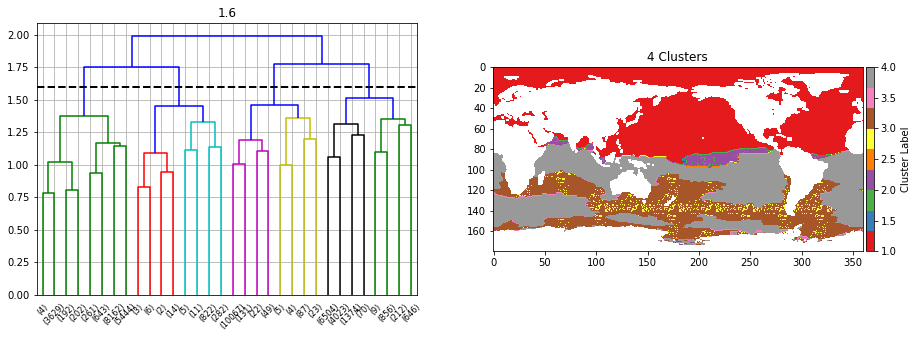

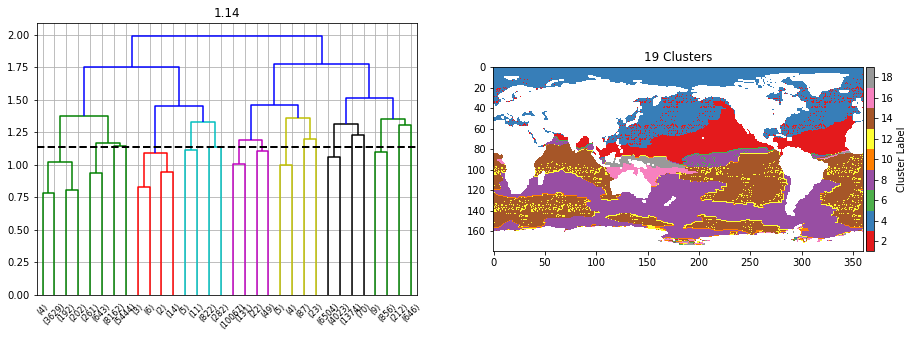

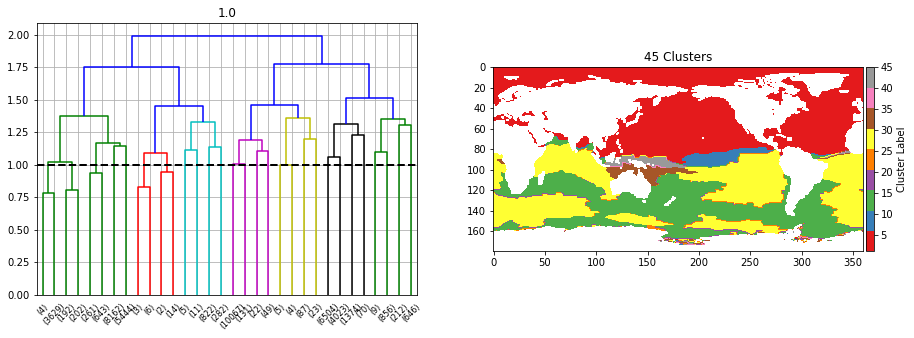

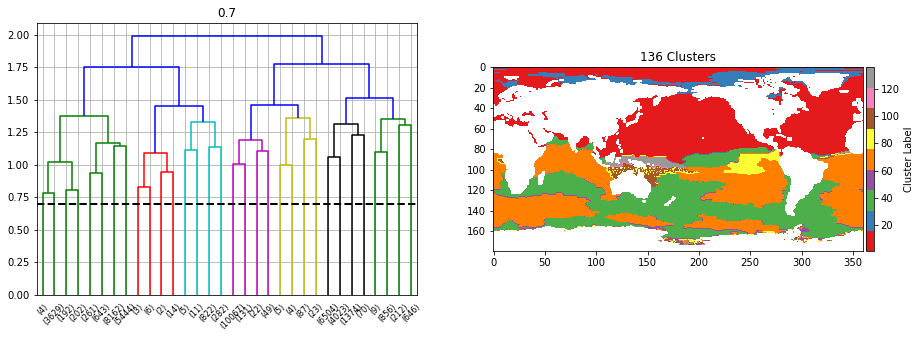

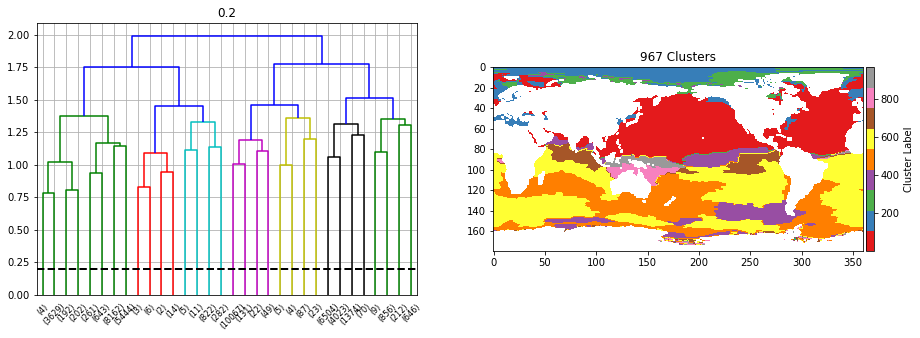

In [161]:
plot2(1.6,ci1, clst1)
plot2(1.14,ci6, clst6)
plot2(1.0,ci11, clst11)
plot2(0.7,ci14, clst14)
plot2(0.2,ci19, clst19)

In the figures above we can see how the different choices of cutoff influences the number of clusters and how these clusters are depicted on the map. For instance the cutoff 1.6 creates 4 clusters as a result the north hemisphere to be all in one cluster. Selecting a cutoff below 0.7 the corresponding  maps represent quite well the north hemishere but it is difficult to interpret the southern hemisphere because of the large number of clusters.